Import relevant libraries

In [1]:
from glob import glob
import pydicom as dicom
import os
import time
import math

from tqdm import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [2]:
rootDir='/kaggle/input/rsna-pneumonia-detection-challenge/'
trainImagesDir=rootDir+'stage_2_train_images/'
testImagesDir=rootDir+'stage_2_test_images/'
sampleSubmission=rootDir+'stage_2_sample_submission.csv'
classInfo=rootDir+'stage_2_detailed_class_info.csv'
rsnaLink=rootDir+'GCP Credits Request Link - RSNA.txt'
trainLabels=rootDir+'stage_2_train_labels.csv'
workingDir='/kaggle/working/'
tempDir='/kaggle/temp/'

In [3]:
imgWidth=224
imgHeight=224
imgChannels=3
imgSize=(imgHeight, imgWidth)
batchSize=64
target={0:'normal',1:'lung opacity'}

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [5]:
def load_dataset(path, df1):
    df=df1.copy(deep=True)
    df['input']=[path+x+'.dcm' for x in df.patientId]
    df.rename(columns={'Target':'output1'},inplace=True)
    df.fillna(0, inplace=True)
    df['output2']=(df.x.map(str) + ' ' + df.y.map(str) + ' ' + df.width.map(str) + ' ' + df.height.map(str))
    df['output2']=df['output2'].apply(lambda d : d.split())
    df.drop(['x','y','width','height', 'patientId'],axis=1, inplace=True)
#     xtrain=df['patientId']
#     ytrain1=df['output1']
#     ytrain2=df['output2']
    
#     return xtrain, ytrain1, ytrain2
    return df

In [6]:
image_target=pd.read_csv(trainLabels)
image_target.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
image_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [24]:
image_target[image_target.Target==0].shape

(20672, 6)

In [8]:
image_target[image_target.Target==1].shape

(9555, 6)

We can observe that the non-null values are 9555 which matches to the patients that have pneumonia problem

In [9]:
# xtrain, ytrain1, ytrain2=load_dataset(trainImagesDir, image_target)
df=load_dataset(trainImagesDir, image_target)
df.head()

,output1,input,output2
0,0,/kaggle/input/rsna-pneumonia-detection-challen...,"[0.0, 0.0, 0.0, 0.0]"
1,0,/kaggle/input/rsna-pneumonia-detection-challen...,"[0.0, 0.0, 0.0, 0.0]"
2,0,/kaggle/input/rsna-pneumonia-detection-challen...,"[0.0, 0.0, 0.0, 0.0]"
3,0,/kaggle/input/rsna-pneumonia-detection-challen...,"[0.0, 0.0, 0.0, 0.0]"
4,1,/kaggle/input/rsna-pneumonia-detection-challen...,"[264.0, 152.0, 213.0, 379.0]"


In [10]:
# xtrain
df.input

0        /kaggle/input/rsna-pneumonia-detection-challen...
1        /kaggle/input/rsna-pneumonia-detection-challen...
2        /kaggle/input/rsna-pneumonia-detection-challen...
3        /kaggle/input/rsna-pneumonia-detection-challen...
4        /kaggle/input/rsna-pneumonia-detection-challen...
                               ...                        
30222    /kaggle/input/rsna-pneumonia-detection-challen...
30223    /kaggle/input/rsna-pneumonia-detection-challen...
30224    /kaggle/input/rsna-pneumonia-detection-challen...
30225    /kaggle/input/rsna-pneumonia-detection-challen...
30226    /kaggle/input/rsna-pneumonia-detection-challen...
Name: input, Length: 30227, dtype: object

In [25]:
df.output1.unique()

array([0, 1])

In [11]:
# ytrain1
df.output1

0        0
1        0
2        0
3        0
4        1
        ..
30222    1
30223    0
30224    0
30225    1
30226    1
Name: output1, Length: 30227, dtype: int64

In [12]:
# ytrain2
df.output2

0                [0.0, 0.0, 0.0, 0.0]
1                [0.0, 0.0, 0.0, 0.0]
2                [0.0, 0.0, 0.0, 0.0]
3                [0.0, 0.0, 0.0, 0.0]
4        [264.0, 152.0, 213.0, 379.0]
                     ...             
30222    [185.0, 298.0, 228.0, 379.0]
30223            [0.0, 0.0, 0.0, 0.0]
30224            [0.0, 0.0, 0.0, 0.0]
30225    [570.0, 393.0, 261.0, 345.0]
30226    [233.0, 424.0, 201.0, 356.0]
Name: output2, Length: 30227, dtype: object

In [13]:
def loadImages(df):
    cols=5
    rows=4
    idx=0
    f,axarr=plt.subplots(rows,cols,figsize=(18,10))
    data=df.sample(n = cols*rows)
    for r in range(rows):
        for c in range(cols):
            image_path = df.input[idx]
            img = dicom.dcmread(image_path).pixel_array
            axarr[r,c].imshow(img, cmap='gray')
            result=target.get(df.output1[idx])
            x,y,w,h=df['output2'].values[0]
#             print(x,y,w,h)
            rect = patches.Rectangle((float(x), float(y)), float(w), float(h), linewidth=3, edgecolor='red')
            axarr[r,c].add_patch(rect)
            bbox=list([x,y,w,h])
            axarr[r,c].set_title(result)
            idx+=1
    plt.tight_layout()

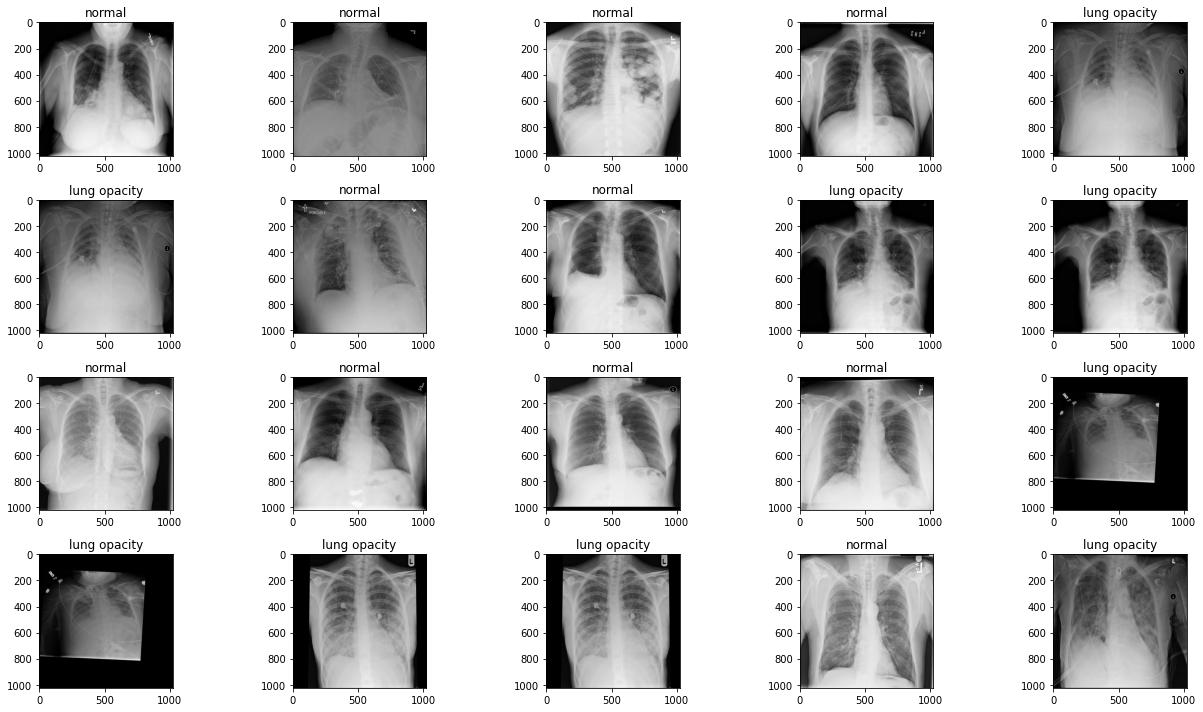

In [14]:
loadImages(df)

In [15]:
def check_images_shape(path):
    img_path=glob(path + '*.dcm')
    # Dict to capture image name (patiendid) as key and image array as value
    imagesShape=[dicom.dcmread(image).pixel_array.shape for image in tqdm(img_path)]
    c=0
    for shape in tqdm(imagesShape):
        if shape != (1024,1024):
            c+=1
    print('{} images have different shape of total {}'.format(c, len(img_path)))


In [16]:
with strategy.scope():
    check_images_shape(trainImagesDir)

100%|██████████| 26684/26684 [00:00<00:00, 1329241.53it/s]

0 images have different shape of total 26684


All the images are of size 1024*1024

Even though the size of the images are same, we can observe the image inside have different aspect ratio, that is, not all images occupy the same space.

In [17]:
c=math.ceil(df.shape[0]*0.7)
train_df,val_df=df[:c],df[c:]
print(train_df.shape, val_df.shape)

(21159, 3) (9068, 3)


In [18]:
class CustomDataGen(Sequence):
    
    def __init__(self, df, x_col, y_col, batch_size, input_size=(224, 224), shuffle=True):
        self.df = df.copy(deep=True)
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.n_class = df[y_col['output1']].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, img_path, size):
        image = dicom.dcmread(img_path).pixel_array
        org_size=image.shape
        image = cv2.resize(image,(size[0],size[1]))
        return preprocess_input(image/255.), org_size
    
    def __get_output0(self, y):
        return y
    
    def __get_output1(self, y, img_size, target_size):
        if y[0]==0:
            return y
        else:
            x1=float(y[0])
            y1=float(y[1])
            w=float(y[2])
            h=float(y[3])
            xmin=math.ceil(x1*target_size[1]/img_size[1])
            ymin=math.ceil(y1*target_size[0]/img_size[0])
            xmax=math.ceil((x1+w)*target_size[1]/img_size[1])
            ymax=math.ceil((y1+h)*target_size[0]/img_size[0])
            width = xmax-xmin
            height = ymax-ymin
            return list([xmin, ymin, width, height])
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.x_col['input']]

        class_batch = batches[self.y_col['output1']]
        bbox_batch = batches[self.y_col['output2']]

        img_batch = [self.__get_input(x, self.input_size) for x in path_batch]
        
        x_batch = [x[0] for x in img_batch]
        img_org_size = [x[1] for x in img_batch]
        y0_batch = [self.__get_output0(y0) for y0 in class_batch]
        y1_batch = [self.__get_output1(y1, org_size, self.input_size) for y1, org_size in zip(bbox_batch, img_org_size)]

        return np.asarray(x_batch), np.asarray(y0_batch)
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        x, y = self.__get_data(batches)
        return x, y
    
    def __len__(self):
        return self.n // self.batch_size
    


In [19]:
traingen = CustomDataGen(train_df,
                         x_col={'input':'input'},
                         y_col={'output1': 'output1', 'output2': 'output2'},
                         batch_size=batchSize, input_size=(imgSize)
                        )

valgen = CustomDataGen(val_df,
                         x_col={'input':'input'},
                         y_col={'output1': 'output1', 'output2': 'output2'},
                         batch_size=batchSize, input_size=(imgSize)
                        )


In [20]:
def loadVGG16(freezelayers=16):
    pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(imgHeight, imgWidth, 3))
 
    for layer in pretrained_model.layers[:freezelayers]:
        layer.trainable = False
 
    for layer in pretrained_model.layers[freezelayers:]:
        layer.trainable = True

    last_layer = pretrained_model.get_layer(index=len(pretrained_model.layers)-1)
    last_output = last_layer.output

    x = Flatten()(last_output)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    o1 = Dense(1, activation='sigmoid')(x)
#     o2 = Dense(4, activation='relu')(x)
  
    model = Model(pretrained_model.input, o1)
    
    return model

In [21]:
model=loadVGG16()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [22]:
model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [23]:
try:
    start=time.time()
    model.fit(  traingen,
                validation_data = valgen,
                epochs=5,
                batch_size=64
            )
    print('Time taken:',time.time()-start)
except Exception as e:
    print(e)

Epoch 1/5
in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.tra